In [1]:
!export PATH="/home/fzaidoun/anaconda3/envs/him/bin:$PATH"

In [2]:
!conda install -c conda-forge dynesty -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/fzaidoun/anaconda3/envs/him

  added / updated specs:
    - dynesty


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    dynesty-1.1                |     pyh44b312d_0          70 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          70 KB

The following NEW packages will be INSTALLED:

  dynesty            conda-forge/noarch::dynesty-1.1-pyh44b312d_0



dynesty-1.1          | 70 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [1]:
import numpy as np
from astropy.io import ascii
from functions import *

In [2]:
print("loading data")
cols = ['sSFR',
        'flag_vsquared',
        'flag_voidfinder']
data = ascii.read('../data_flags_updated_Nov1.dat', include_names=cols)
sSFR = data['sSFR']

print("loading classification")
#classification V^2
wall_v2 = np.argwhere(data['flag_vsquared'] == 0).flatten()
void_v2 = np.argwhere(data['flag_vsquared'] == 1).flatten()
edge_v2 = np.argwhere(data['flag_vsquared'] == 2).flatten()
out_v2 = np.argwhere(data['flag_vsquared'] == 9).flatten()

#classification voidfinder
wall_vf = np.argwhere(data['flag_voidfinder'] == 0).flatten()
void_vf = np.argwhere(data['flag_voidfinder'] == 1).flatten()
edge_vf = np.argwhere(data['flag_voidfinder'] == 2).flatten()
out_vf = np.argwhere(data['flag_voidfinder'] == 9).flatten()

## property variables
print("loading property model variables")

# data and range
data1_wall_vf = remove_nan(sSFR[wall_vf])
data2_void_vf = remove_nan(sSFR[void_vf])
data1_wall_v2 = remove_nan(sSFR[wall_v2])
data2_void_v2 = remove_nan(sSFR[void_v2])
bins_ = np.linspace(-13,-8, 170) #np.linspace(-3,2, 250)#np.linspace(0,4, 170)
label_vf = 'sSFR_VF'
label_v2 = 'sSFR_V2'

loading data
loading classification
loading property model variables


In [10]:
bounds1 = [[0, 3],     # s ........ scale factor (peak 1 to 2) #2.5

           [100., 1000.],  # a ........ skew normal 1 amplitude # 2000 and 100
           [-13., -10.5],     # mu_a ..... skew normal 1 location  # 0.5
           [0.1,2.],     # sigma_a .. skew normal 1 scale #0.2
           [-10., 10.],    # a_skew ... skew normal 1 skew

           [100, 4000.],  # b ........ skew normal 2 amplitude #6100 and 150
           [-10.2, -9],     # mu_b ..... skew normal 2 location #0.9  # should not overlap with mu_a
           [0.1, 2],     # sigma_b .. skew normal 2 scale #0.1
           [-10., 10.]]    # b_skew ... skew normal 2 skew

# [ 5.10627839e-01,  7.83682695e+02, -8.86655486e-01,  3.44599372e-01,
# -1.49398220e+00,  2.76013422e+03,  4.49217048e-01,  8.99151610e-01,
# -2.46410872e+00]

In [11]:
def prior_xform1(u):
    """Priors for the 9 parameters of model M1. Required by the dynesty sampler.

    Parameters
    ----------
    u : ndarray
        Array of uniform random numbers between 0 and 1.

    Returns
    -------
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    """
    s       = uniform(0.1, 10., u[0])
    a       = jeffreys(1., 1e4, u[1])
    mu_a    = uniform(-13., -10.5, u[2])
    sigma_a = jeffreys(0.1, 2., u[3])
    xi_a    = uniform(-10., 10., u[4])
    b       = jeffreys(1., 1e4, u[5])
    mu_b    = uniform(-10.2, -9, u[6])
    sigma_b = jeffreys(0.05, 2., u[7])
    xi_b    = uniform(-10., 10., u[8])

    return s, a, mu_a, sigma_a, xi_a, b, mu_b, sigma_b, xi_b

In [12]:
bounds1_ = [[100., 5000.],  # change after running model 1
        [-12, -10.5],     # mu_a ..... skew normal 1 location #0.5
        [0.1, 2.0],     # sigma_a .. skew normal 1 scale #0.7
        [-10, 10],    # a_skew ... skew normal 1 skew
        [100., 5000.],  # b ........ skew normal 2 amplitude #6100
        [-10.2, -9],     # mu_b ..... skew normal 2 location #0.9
        [0.1, 2.0],     # sigma_b .. skew normal 2 scale #0.4
        [-10., 10]]    # a_skew ... skew normal 2 skew

bounds2_ = [[100., 7000.],    # change after running model 1
            [-12, -10.5],     # mu_g ..... skew normal 3 location #0.5
            [0.1, 2.0],     # sigma_g .. skew normal 3 scale #0.6
            [-10, 10.],    # g_skew ... skew normal 3 skew
            [100., 6500.],   # d ........ skew normal 4 amplitude #800
            [-10.2, -9],     # mu_d ..... skew normal 4 location #0.8
            [0.1, 2.0],     # sigma_d .. skew normal 4 scale #0.3
            [-10., 10]]    # d_skew ... skew normal 4 skew
bounds2 = bounds1_ + bounds2_


In [13]:
def prior_xform2(u):
    """Priors for the 9 parameters of model M1. Required by the dynesty sampler.

    Parameters
    ----------
    u : ndarray
        Array of uniform random numbers between 0 and 1.

    Returns
    -------
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    """
    a       = jeffreys(1., 1e4, u[0])
    mu_a    = uniform(-12, -10.5, u[1])
    sigma_a = jeffreys(0.1, 2., u[2])
    xi_a    = uniform(-10., 10., u[3])
    b       = jeffreys(1., 1e4, u[4])
    mu_b    = uniform(-10.2, -9, u[5])
    sigma_b = jeffreys(0.05, 1., u[6])
    xi_b    = uniform(-10., 10., u[7])

    g       = jeffreys(1., 1e4, u[8])
    mu_g    = uniform(-12, -10.5, u[9])
    sigma_g = jeffreys(0.1, 2., u[10])
    xi_g    = uniform(-10., 10., u[11])
    d       = jeffreys(1., 1e4, u[12])
    mu_d    = uniform(-10.2, -9, u[13])
    sigma_d = jeffreys(0.05, 2., u[14])
    xi_d    = uniform(-10., 10., u[15])

    return a, mu_a, sigma_a, xi_a, \
           b, mu_b, sigma_b, xi_b, \
           g, mu_g, sigma_g, xi_g, \
           d, mu_d, sigma_d, xi_d


VoidFinder (VF)
plotting histograms of data...


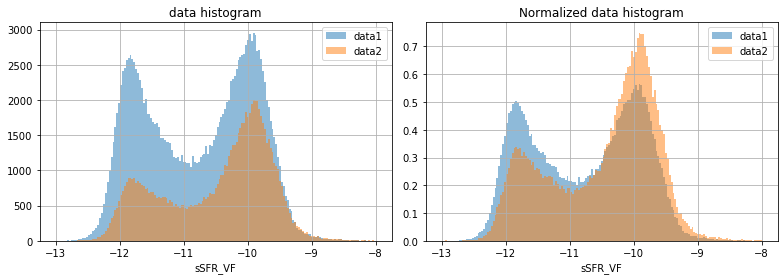

Running Model 1 using VF...


In [3]:

#for VF
print("VoidFinder (VF)")
plot_hist(data1_wall_vf,data2_void_vf,bins_,label_vf)
#model 1
print("Running Model 1 using VF...")

running minimizer...this might take a few minutes...


/gpfs/fs1/home/fzaidoun/Desktop/copy/desi_void_comparison/mixture-models/functions.py:135: RuntimeWarning: divide by zero encountered in log
  return np.sum(m*np.log(lambda1) - lambda1 - gammaln(m+1) + n*np.log(lambda2) - lambda2 - gammaln(n+1))
/gpfs/fs1/home/fzaidoun/Desktop/copy/desi_void_comparison/mixture-models/functions.py:135: RuntimeWarning: invalid value encountered in multiply
  return np.sum(m*np.log(lambda1) - lambda1 - gammaln(m+1) + n*np.log(lambda2) - lambda2 - gammaln(n+1))


best fit parameters       fun: 11985.609123831891
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.82165440e-02, -9.36578711e+00,  7.38327738e-01, -1.11140253e+00,
        1.00590115e-01,  3.63801728e-04,  3.34694023e-01,  1.05665095e+00,
        4.43833417e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1930
      nit: 132
     njev: 193
   status: 0
  success: True
        x: array([ 5.39732609e-01,  1.00000000e+03, -1.20312513e+01,  3.57642164e-01,
        1.98276729e+00,  3.94857387e+03, -9.52680669e+00,  1.07578727e+00,
       -3.44476959e+00])


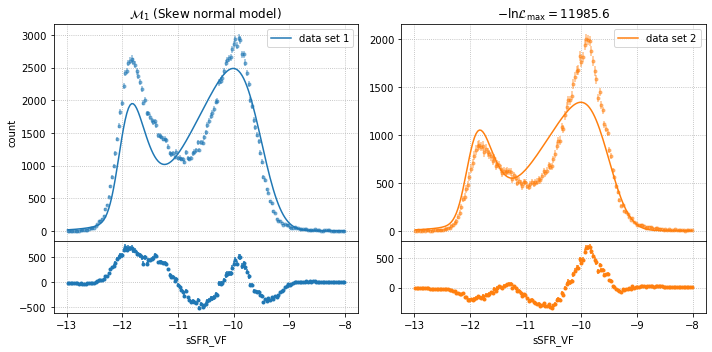

In [5]:
Model_1_fit(bounds1,data1_wall_vf,data2_void_vf,bins_,label_vf)


running the nested sampler... this might take from minutes to hours...


iter: 43352 | batch: 7 | bound: 794 | nc: 10 | ncall: 689451 | eff(%):  6.288 | loglstar: -6312.575 < -6303.454 < -6306.182 | logz: -6356.870 +/-  0.436 | stop:  0.960                               

sampler output saved as pickle file 'sampler_results_model1_sSFR_VF'
plotting corner plots...
The maximum a posteriori (MAP) values of the parameters:  [ 5.11645350e-01  2.87423283e+03 -1.21432476e+01  1.14675700e+00
  6.69405673e+00  2.34353909e+03 -9.75126586e+00  3.90285312e-01
 -8.79316813e-01]
Best fit results: 
Bayesian Evidence for model 1 :  -6356.856462927184


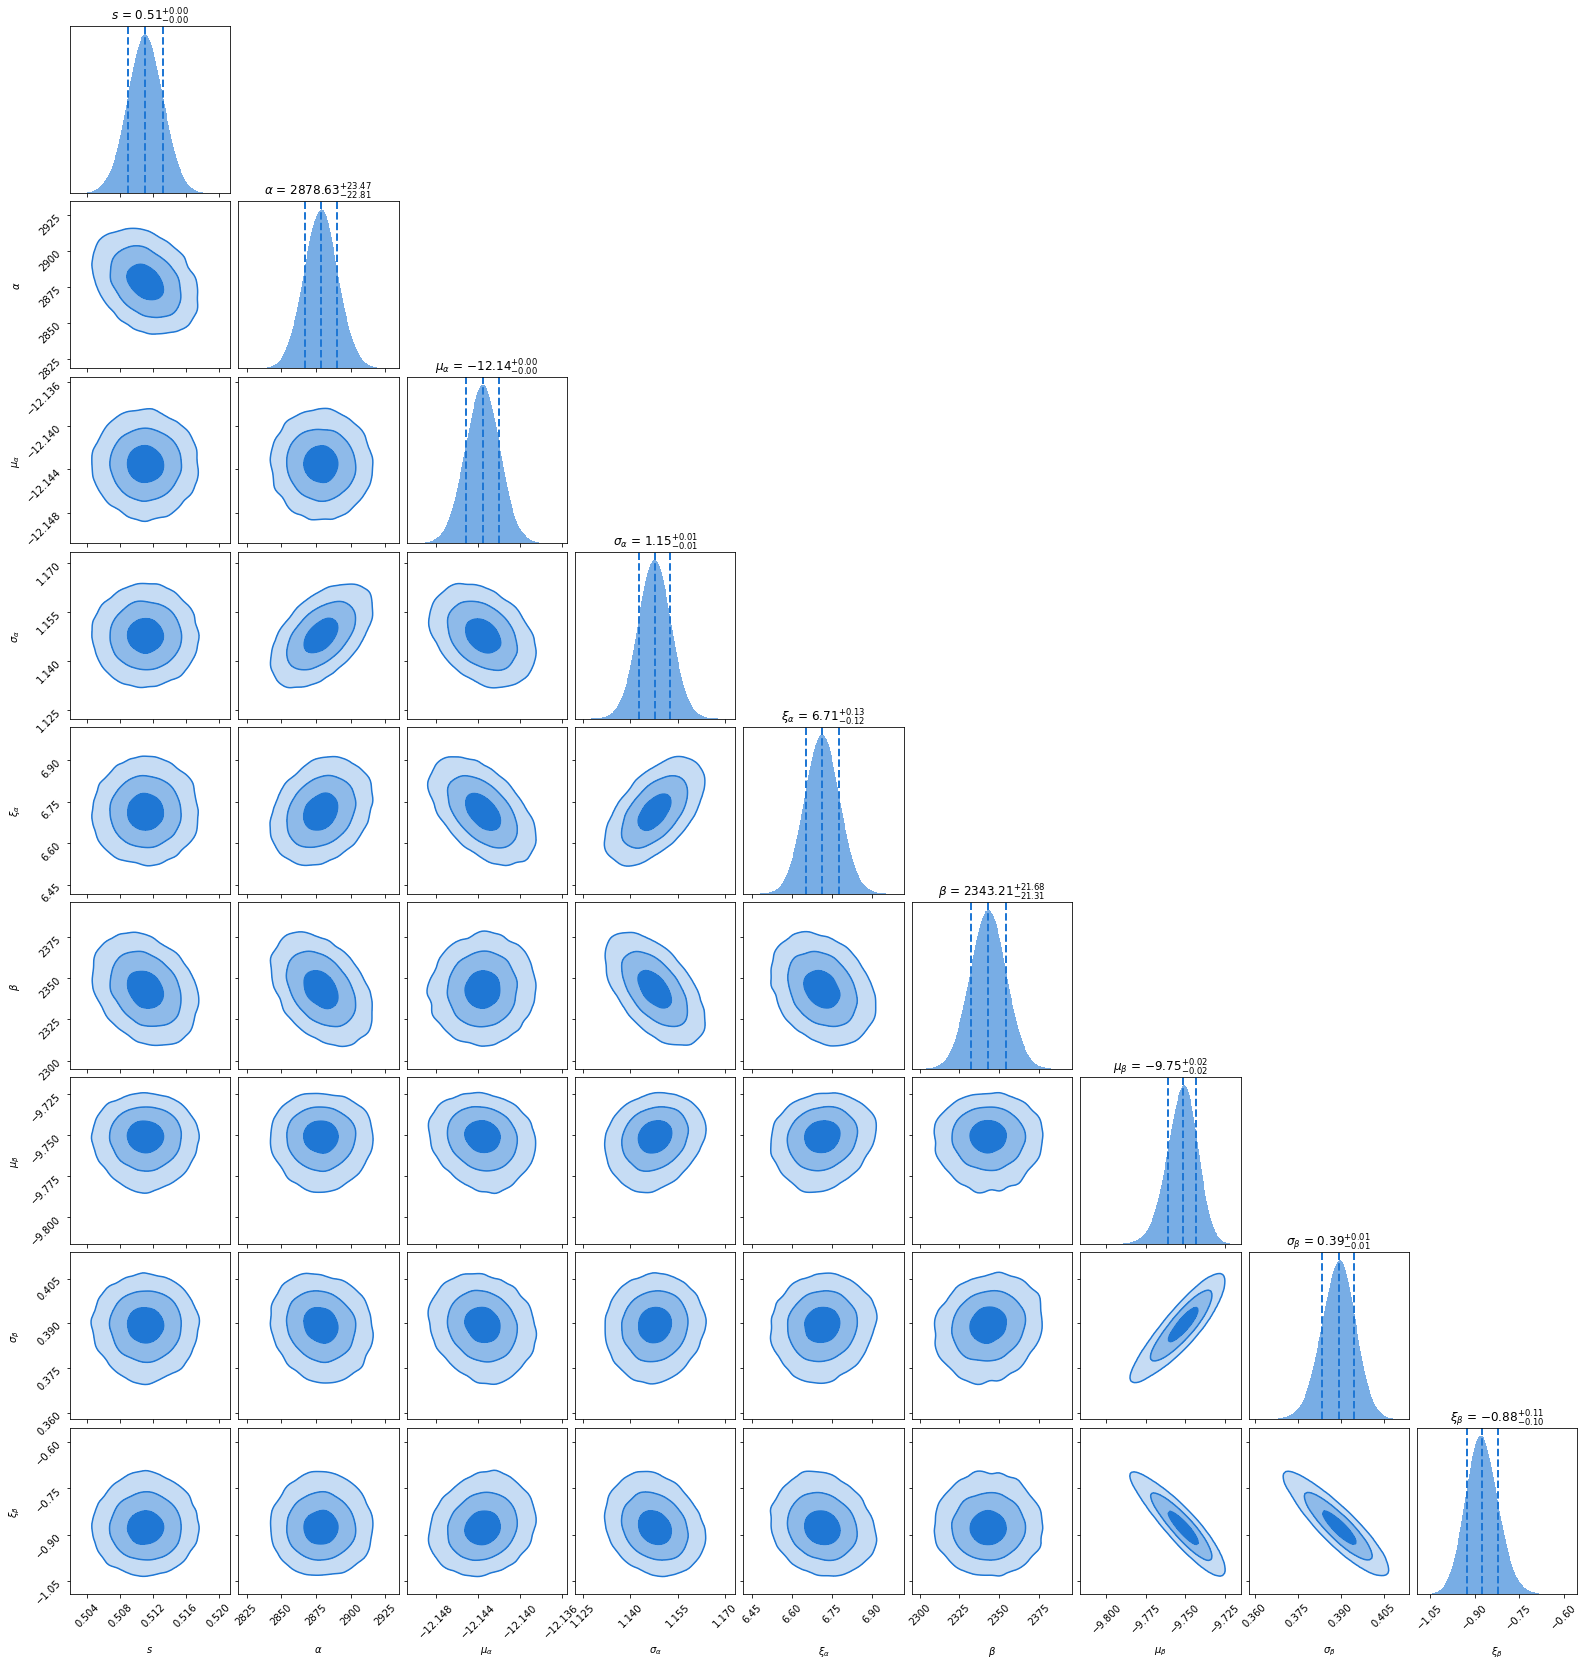

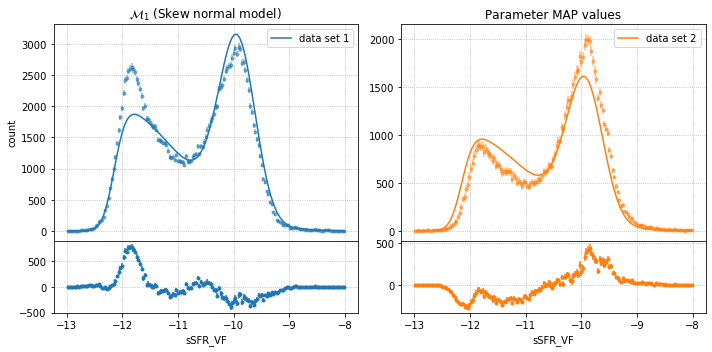

In [14]:
Model_1_sampler(prior_xform1,data1_wall_vf,data2_void_vf,bins_,label_vf)
lnZ1_vf = Model1_output(data1_wall_vf,data2_void_vf,bins_,label_vf)

running minimizer...this might take a few minutes...
plotting best fit results...


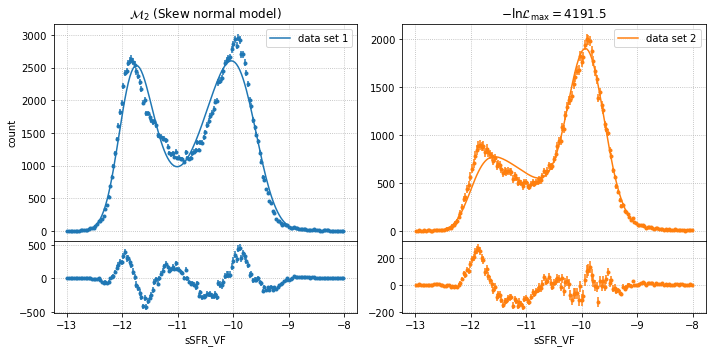

In [9]:
Model_2_fit(bounds2,data1_wall_vf,data2_void_vf,bins_,label_vf)


Running Model 2 using VF...
running the nested sampler... this might take from minutes to hours...


iter: 1780 | batch: 0 | bound: 1 | nc: 25 | ncall: 17391 | eff(%):  9.949 | loglstar:   -inf < -528763.406 <    inf | logz: -528773.870 +/-  0.204 | dlogz: 451911.729 >  0.010                       /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
iter: 14439 | batch: 0 | bound: 190 | nc: 25 | ncall: 339408 | eff(%):  4.248 | loglstar:   -inf < -13651.762 <    inf | logz: -13687.121 +/-  0.371 | dlogz: 4553.873 >  0.010                       /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserW

/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 17144 | batch: 0 | bound: 241 | nc: 25 | ncall: 445692 | eff(%):  3.842 | loglstar:   -inf < -9243.071 <    inf | logz: -9283.997 +/-  0.401 | dlogz: 2440.098 >  0.010                         /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
iter: 17507 | batch: 0 | bound: 247 | 

iter: 19116 | batch: 0 | bound: 282 | nc: 25 | ncall: 553075 | eff(%):  3.453 | loglstar:   -inf < -7387.481 <    inf | logz: -7430.269 +/-  0.411 | dlogz: 1519.268 >  0.010                         /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 19129 | batch: 0 | bound: 284 | nc: 25 | ncall: 557393 | eff(%):  3.429 | loglstar:   -inf < -7381.906 <    inf | logz: -7425.280 +/-  0.412 | dlogz: 1514.369 >  0.010                         /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserW

/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 21580 | batch: 0 | bound: 332 | nc: 25 | ncall: 682897 | eff(%):  3.158 | loglstar:   -inf < -6033.235 <    inf | logz: -6082.247 +/-  0.440 | dlogz: 913.463 >  0.010                          /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 21921 | batch: 0 | bound: 338 | 

iter: 24182 | batch: 0 | bound: 382 | nc: 25 | ncall: 824238 | eff(%):  2.932 | loglstar:   -inf < -5177.088 <    inf | logz: -5230.193 +/-  0.456 | dlogz: 566.222 >  0.010                          /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 24470 | batch: 0 | bound: 387 | nc: 25 | ncall: 841615 | eff(%):  2.906 | loglstar:   -inf < -5114.551 <    inf | logz: -5167.747 +/-  0.457 | dlogz: 503.111 >  0.010                          /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserW

/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 28133 | batch: 0 | bound: 450 | nc: 25 | ncall: 1063691 | eff(%):  2.644 | loglstar:   -inf < -4549.399 <    inf | logz: -4609.194 +/-  0.485 | dlogz: 202.242 >  0.010                         /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 28706 | batch: 0 | bound: 459 | 

iter: 32345 | batch: 0 | bound: 521 | nc: 25 | ncall: 1304442 | eff(%):  2.479 | loglstar:   -inf < -4295.142 <    inf | logz: -4362.622 +/-  0.516 | dlogz: 103.262 >  0.010                         /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 32568 | batch: 0 | bound: 525 | nc: 25 | ncall: 1320072 | eff(%):  2.466 | loglstar:   -inf < -4287.627 <    inf | logz: -4355.397 +/-  0.517 | dlogz: 95.587 >  0.010                          /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserW

/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 35032 | batch: 0 | bound: 573 | nc: 25 | ncall: 1533000 | eff(%):  2.284 | loglstar:   -inf < -4225.008 <    inf | logz: -4297.304 +/-  0.533 | dlogz: 42.984 >  0.010                          /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 35099 | batch: 0 | bound: 575 | 

iter: 38761 | batch: 0 | bound: 638 | nc: 25 | ncall: 1807885 | eff(%):  2.143 | loglstar:   -inf < -4178.348 <    inf | logz: -4256.823 +/-  0.555 | dlogz: 16.617 >  0.010                          /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 39056 | batch: 0 | bound: 643 | nc: 25 | ncall: 1831693 | eff(%):  2.132 | loglstar:   -inf < -4176.011 <    inf | logz: -4255.169 +/-  0.557 | dlogz: 15.868 >  0.010                          /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserW

/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 44494 | batch: 0 | bound: 731 | nc: 25 | ncall: 2168871 | eff(%):  2.051 | loglstar:   -inf < -4152.517 <    inf | logz: -4240.218 +/-  0.584 | dlogz:  3.084 >  0.010                          /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 45839 | batch: 0 | bound: 750 | 

sampler output saved as pickle file 'sampler_results_model2_sSFR_VF'
plotting corner plots...
The maximum a posteriori (MAP) values of the parameters:  [ 2.14688716e+03 -1.19967283e+01  4.93971660e-01  1.78294250e+00
  3.07029035e+03 -9.67023546e+00  6.71981071e-01 -1.82604770e+00
  1.26829382e+03 -1.19965754e+01  1.18572082e+00  5.19566022e+00
  1.39810649e+03 -9.80725230e+00  3.49979622e-01 -4.38188076e-01]
Best fit results: 
Bayesian Evidence for model 2 :  -4239.446657903645


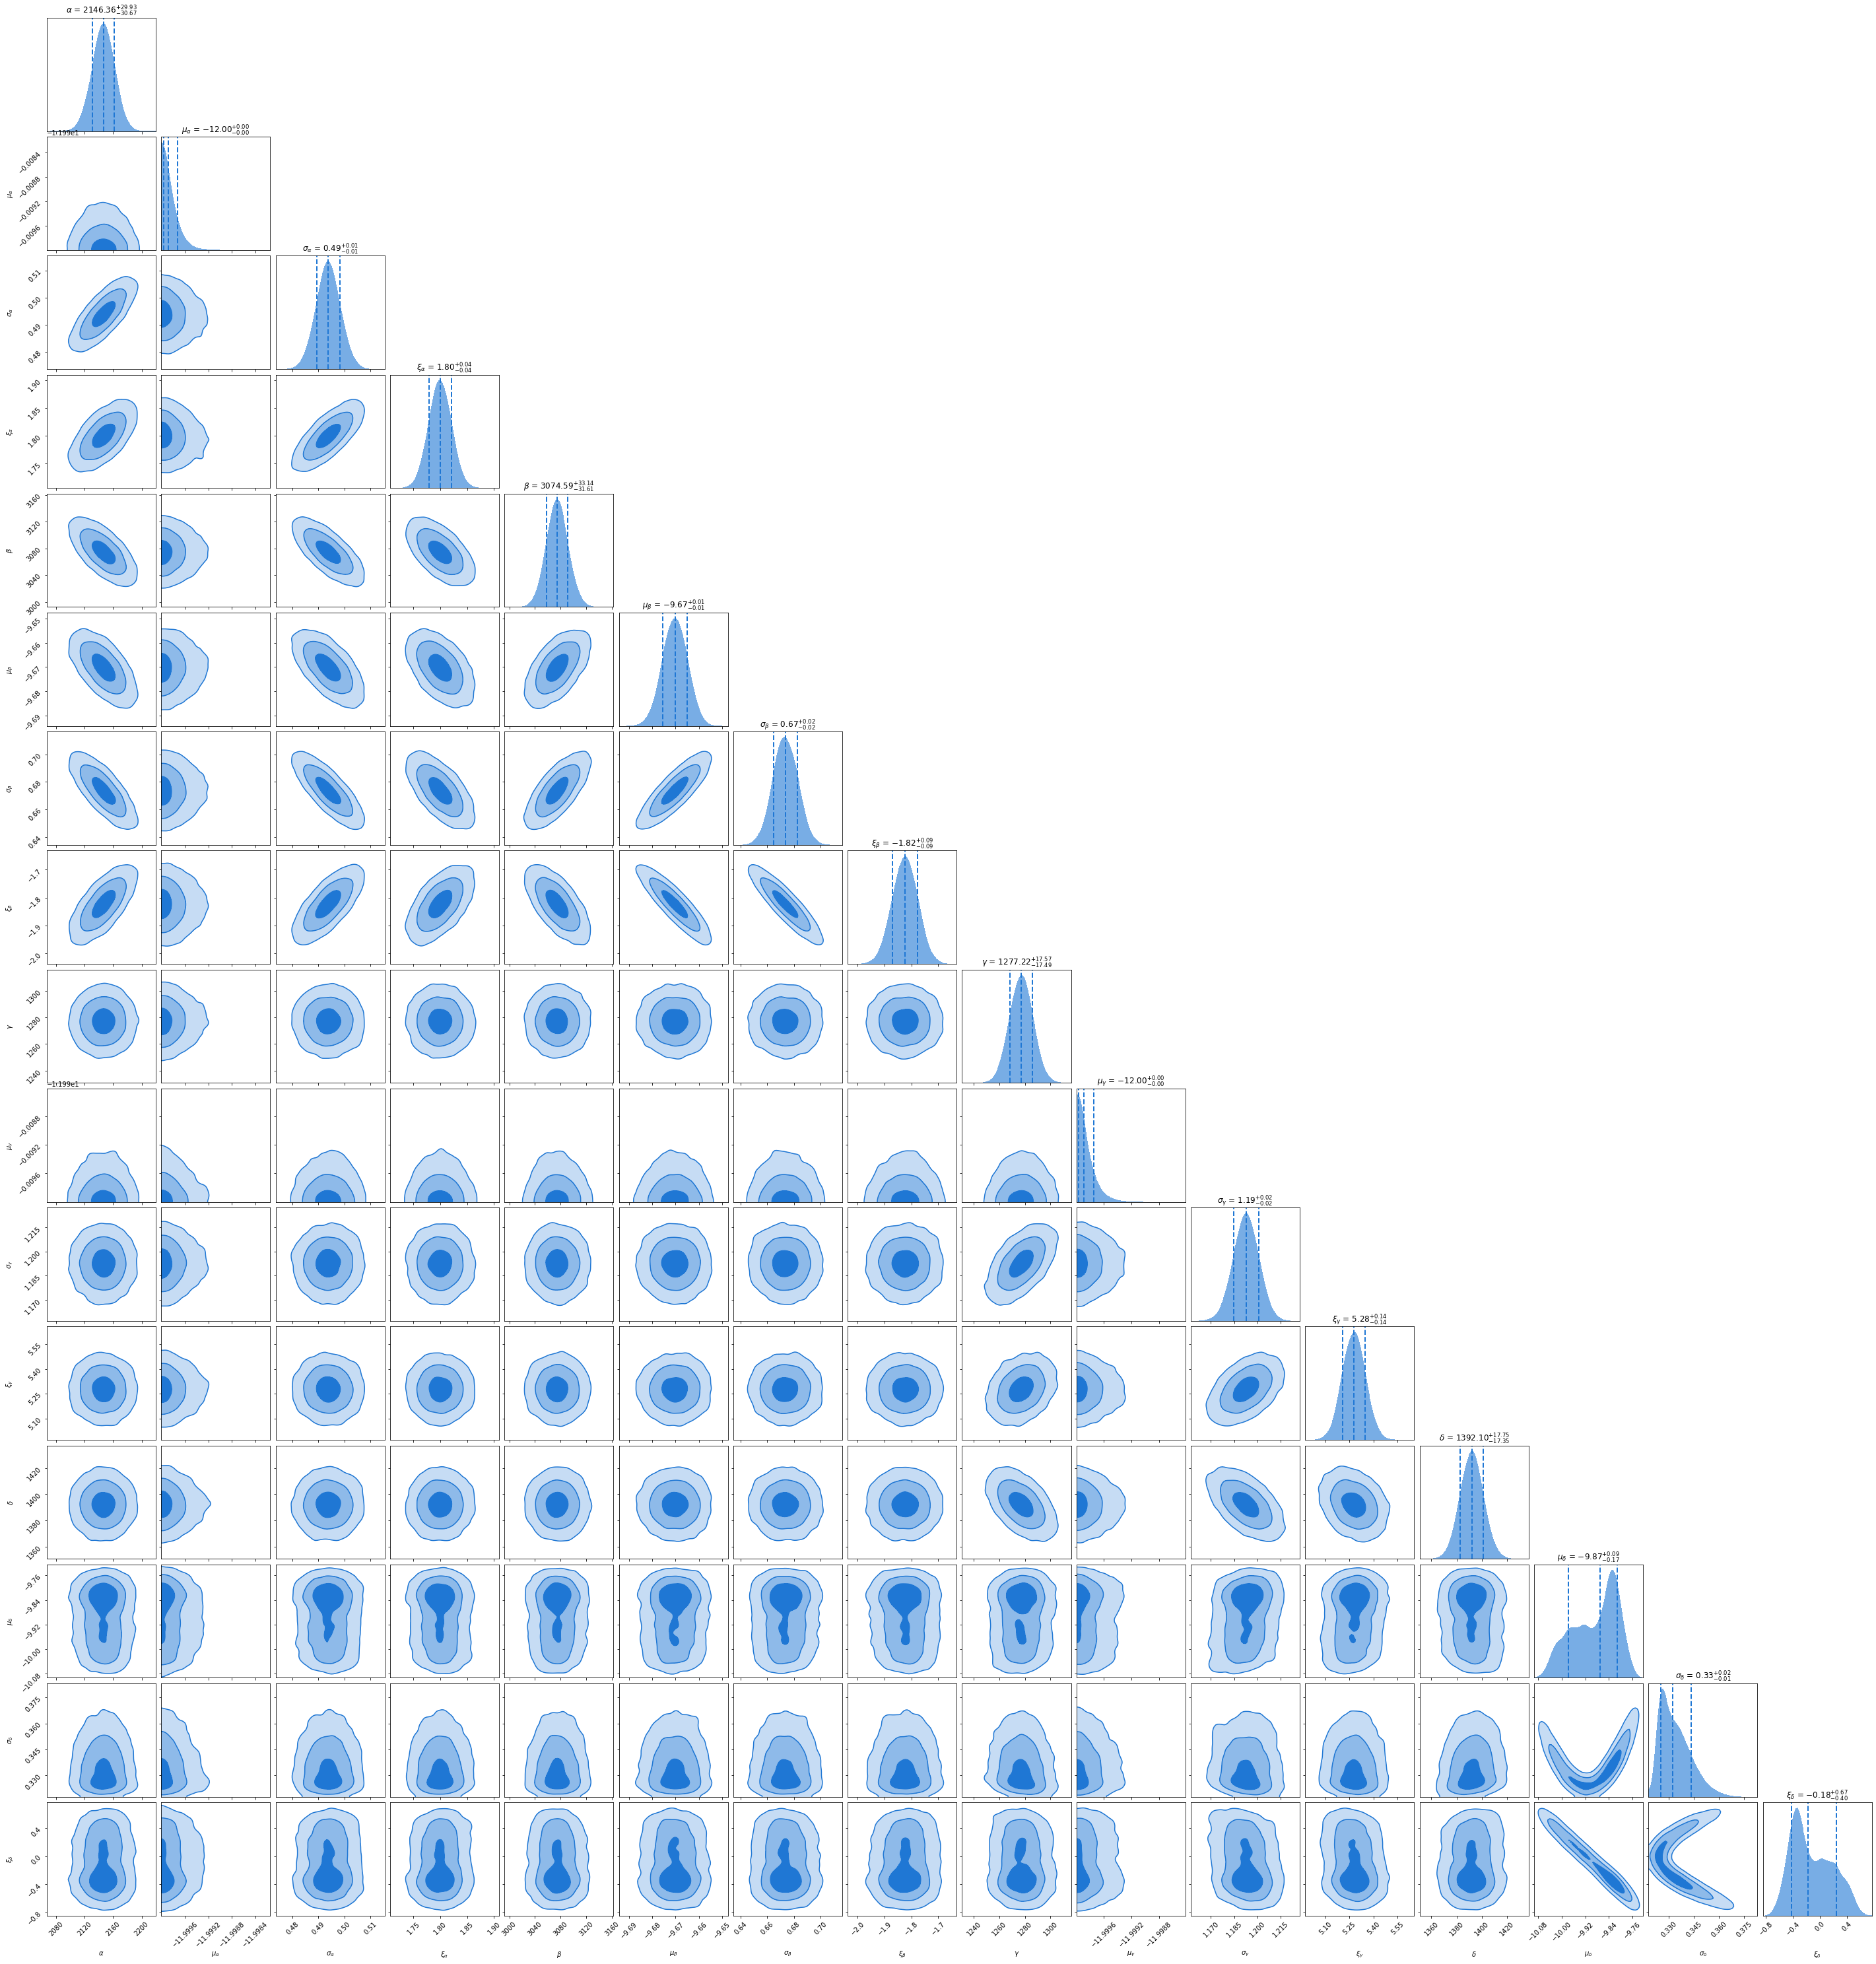

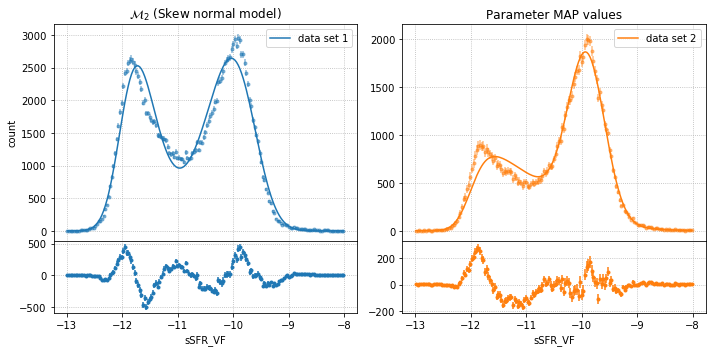

In [15]:
#model2
print("Running Model 2 using VF...")

Model_2_sampler(prior_xform2,data1_wall_vf,data2_void_vf,bins_,label_vf)
lnZ2_vf = Model2_output(data1_wall_vf,data2_void_vf,bins_,label_vf)




In [16]:
#Baye's Factor
lnB12_vf = lnZ1_vf - lnZ2_vf
logB12_vf = np.log10(np.e) * lnB12_vf
print("Log10 of Baye's Factor for g-r using VF is: ", logB12_vf)


Log10 of Baye's Factor for g-r using VF is:  -919.5793942495633


V2
plotting histograms of data...


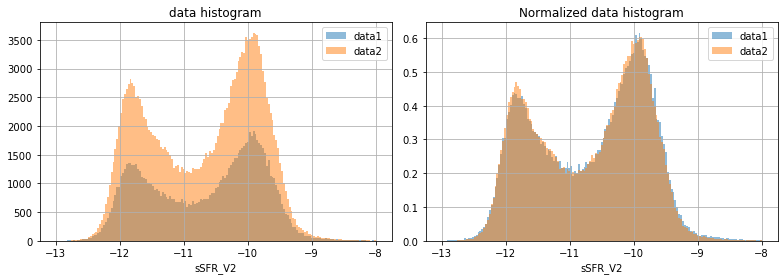

Running Model 1 using V2...
running minimizer...this might take a few minutes...


/gpfs/fs1/home/fzaidoun/Desktop/copy/desi_void_comparison/mixture-models/functions.py:135: RuntimeWarning: divide by zero encountered in log
  return np.sum(m*np.log(lambda1) - lambda1 - gammaln(m+1) + n*np.log(lambda2) - lambda2 - gammaln(n+1))
/gpfs/fs1/home/fzaidoun/Desktop/copy/desi_void_comparison/mixture-models/functions.py:135: RuntimeWarning: invalid value encountered in multiply
  return np.sum(m*np.log(lambda1) - lambda1 - gammaln(m+1) + n*np.log(lambda2) - lambda2 - gammaln(n+1))


best fit parameters       fun: 5958.992308886211
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.11595001e-01, -5.10226123e+00,  2.49201528e-02, -3.25599102e-02,
        9.09494707e-04, -1.54615734e-03,  9.40417444e-02, -5.14773999e-02,
        5.54791771e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1720
      nit: 123
     njev: 172
   status: 0
  success: True
        x: array([ 2.02801689e+00,  1.00000000e+03, -1.20479943e+01,  5.05895603e-01,
        2.28598666e+00,  1.95462760e+03, -9.61241141e+00,  7.55737088e-01,
       -2.04670081e+00])
running the nested sampler... this might take from minutes to hours...


iter: 39081 | batch: 6 | bound: 734 | nc: 32 | ncall: 644597 | eff(%):  6.063 | loglstar: -3512.643 < -3505.122 < -3512.045 | logz: -3556.823 +/-  0.435 | stop:  0.991                               

sampler output saved as pickle file 'sampler_results_model1_sSFR_V2'
plotting corner plots...
The maximum a posteriori (MAP) values of the parameters:  [ 1.93135254e+00  1.75310487e+03 -1.21448528e+01  1.15978224e+00
  6.58316113e+00  1.35021847e+03 -9.75560765e+00  3.87223066e-01
 -8.64014971e-01]
Best fit results: 
Bayesian Evidence for model 1 :  -3556.7989768683115
Running Model 2 using V2...


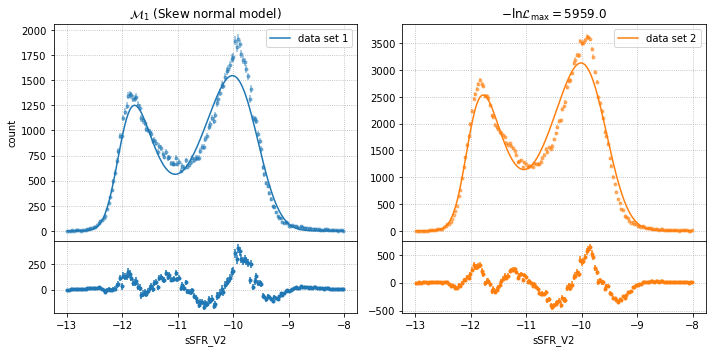

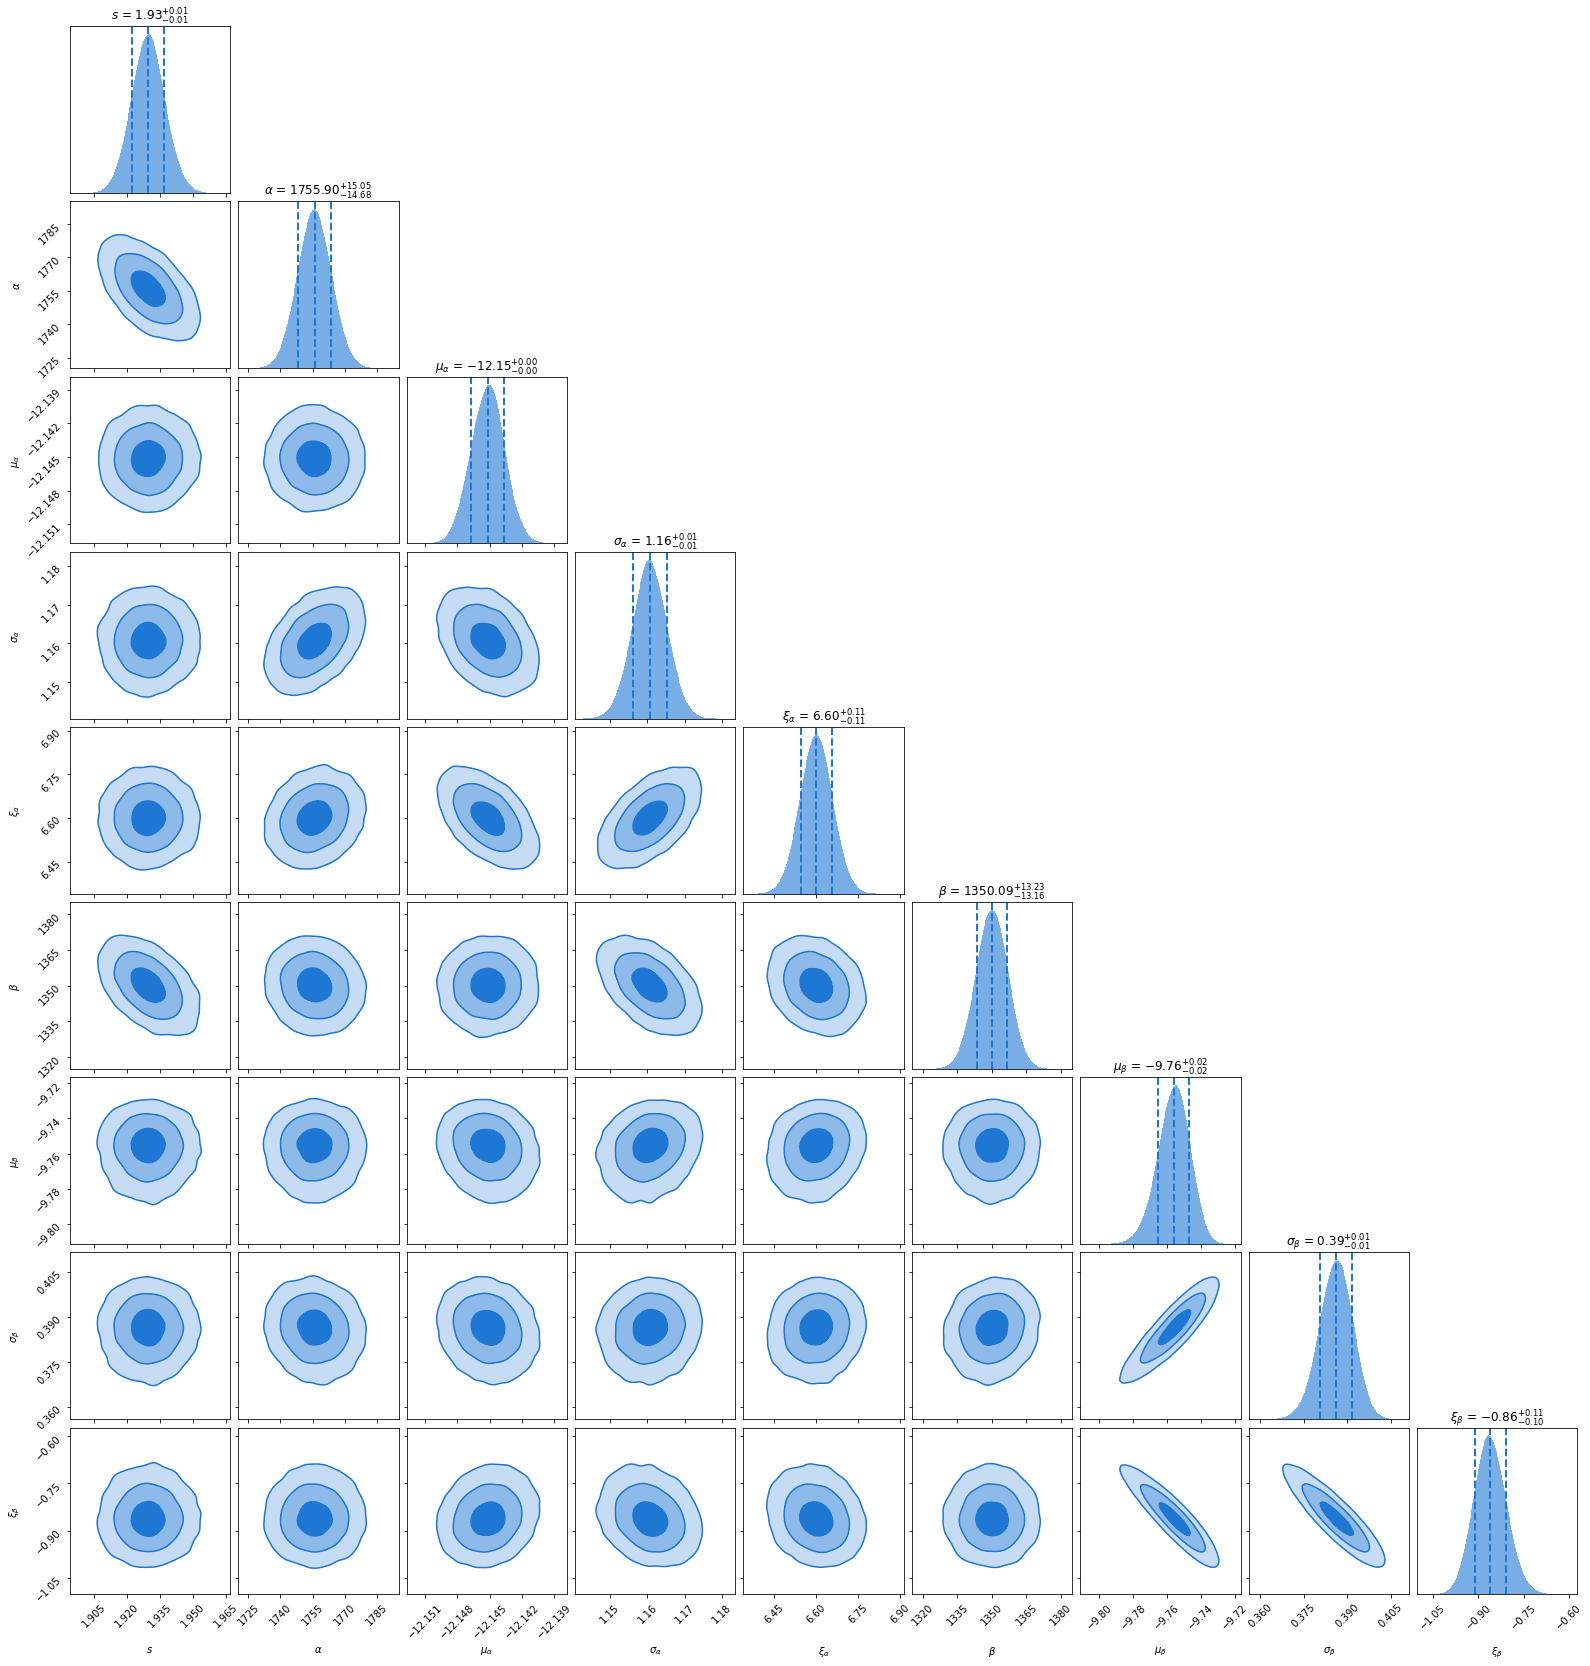

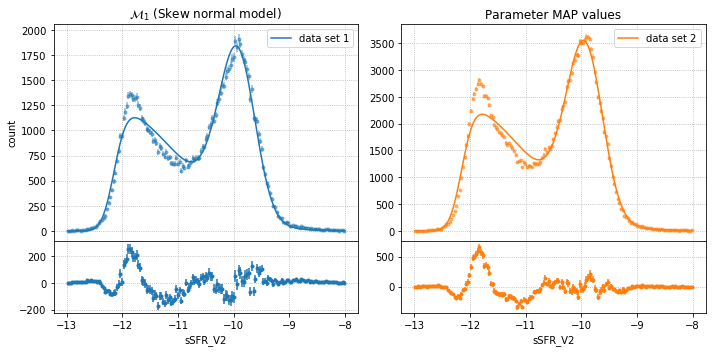

In [17]:


#for V2
print("V2")
plot_hist(data1_wall_v2,data2_void_v2,bins_,label_v2)
print("Running Model 1 using V2...")

#model 1
Model_1_fit(bounds1,data1_wall_v2,data2_void_v2,bins_,label_v2)
Model_1_sampler(prior_xform1,data1_wall_v2,data2_void_v2,bins_,label_v2)
lnZ1_v2 = Model1_output(data1_wall_v2,data2_void_v2,bins_,label_v2)

print("Running Model 2 using V2...")



running minimizer...this might take a few minutes...
plotting best fit results...
running the nested sampler... this might take from minutes to hours...


iter: 11494 | batch: 0 | bound: 144 | nc: 25 | ncall: 262573 | eff(%):  4.369 | loglstar:   -inf < -24976.336 <    inf | logz: -25005.965 +/-  0.341 | dlogz: 11128.869 >  0.010                      /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 13221 | batch: 0 | bound: 173 | nc: 25 | ncall: 312780 | eff(%):  4.220 | loglstar:   -inf < -18527.855 <    inf | logz: -18560.752 +/-  0.358 | dlogz: 7877.621 >  0.010                       /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserW

iter: 16940 | batch: 0 | bound: 239 | nc: 25 | ncall: 450641 | eff(%):  3.755 | loglstar:   -inf < -10573.542 <    inf | logz: -10613.207 +/-  0.397 | dlogz: 3030.602 >  0.010                       /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 17200 | batch: 0 | bound: 244 | nc: 25 | ncall: 463474 | eff(%):  3.707 | loglstar:   -inf < -10255.216 <    inf | logz: -10295.663 +/-  0.398 | dlogz: 2712.584 >  0.010                       /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserW

/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 20762 | batch: 0 | bound: 306 | nc: 25 | ncall: 624077 | eff(%):  3.324 | loglstar:   -inf < -7459.420 <    inf | logz: -7505.852 +/-  0.428 | dlogz: 1145.043 >  0.010                         /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 21650 | batch: 0 | bound: 319 | 

iter: 23424 | batch: 0 | bound: 355 | nc: 25 | ncall: 776412 | eff(%):  3.015 | loglstar:   -inf < -6479.043 <    inf | logz: -6530.504 +/-  0.449 | dlogz: 670.092 >  0.010                          /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 23723 | batch: 0 | bound: 360 | nc: 25 | ncall: 796568 | eff(%):  2.976 | loglstar:   -inf < -6403.509 <    inf | logz: -6455.873 +/-  0.454 | dlogz: 594.999 >  0.010                          /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserW

/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 26950 | batch: 0 | bound: 417 | nc: 25 | ncall: 970480 | eff(%):  2.776 | loglstar:   -inf < -5799.284 <    inf | logz: -5856.929 +/-  0.477 | dlogz: 305.746 >  0.010                          /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 27451 | batch: 0 | bound: 425 | 

iter: 33127 | batch: 0 | bound: 514 | nc: 25 | ncall: 1266726 | eff(%):  2.614 | loglstar:   -inf < -5384.652 <    inf | logz: -5453.271 +/-  0.520 | dlogz: 72.750 >  0.010                          /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 34017 | batch: 0 | bound: 527 | nc: 25 | ncall: 1298739 | eff(%):  2.618 | loglstar:   -inf < -5359.415 <    inf | logz: -5429.700 +/-  0.526 | dlogz: 73.294 >  0.010                          /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserW

/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 37455 | batch: 0 | bound: 588 | nc: 25 | ncall: 1538625 | eff(%):  2.434 | loglstar:   -inf < -5294.032 <    inf | logz: -5370.616 +/-  0.549 | dlogz: 35.570 >  0.010                          /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 37665 | batch: 0 | bound: 592 | 

iter: 42239 | batch: 0 | bound: 668 | nc: 25 | ncall: 1815108 | eff(%):  2.326 | loglstar:   -inf < -5250.515 <    inf | logz: -5335.421 +/-  0.578 | dlogz: 14.859 >  0.010                          /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 42342 | batch: 0 | bound: 671 | nc: 25 | ncall: 1831390 | eff(%):  2.311 | loglstar:   -inf < -5249.871 <    inf | logz: -5335.058 +/-  0.578 | dlogz: 14.290 >  0.010                          /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserW

/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 46853 | batch: 0 | bound: 746 | nc: 25 | ncall: 2145536 | eff(%):  2.183 | loglstar:   -inf < -5233.787 <    inf | logz: -5326.275 +/-  0.599 | dlogz:  4.678 >  0.010                          /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 47047 | batch: 0 | bound: 750 | 

iter: 50279 | batch: 0 | bound: 807 | nc: 25 | ncall: 2467984 | eff(%):  2.037 | loglstar:   -inf < -5228.503 <    inf | logz: -5325.337 +/-  0.606 | dlogz:  0.380 >  0.010                          /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 50763 | batch: 0 | bound: 815 | nc: 25 | ncall: 2505932 | eff(%):  2.025 | loglstar:   -inf < -5228.019 <    inf | logz: -5325.317 +/-  0.606 | dlogz:  0.159 >  0.010                          /home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/dynesty/sampling.py:221: UserW

sampler output saved as pickle file 'sampler_results_model2_sSFR_V2'
plotting corner plots...
The maximum a posteriori (MAP) values of the parameters:  [ 1.31265617e+03 -1.19964631e+01  6.19936698e-01  2.16236007e+00
  1.79049240e+03 -1.00452346e+01  4.64691621e-01  3.39749777e-01
  2.41656343e+03 -1.19984621e+01  5.53192806e-01  2.13305938e+00
  3.57179978e+03 -9.71482033e+00  5.68109667e-01 -1.28133604e+00]
Best fit results: 
Bayesian Evidence for model 2 :  -5325.154903957387


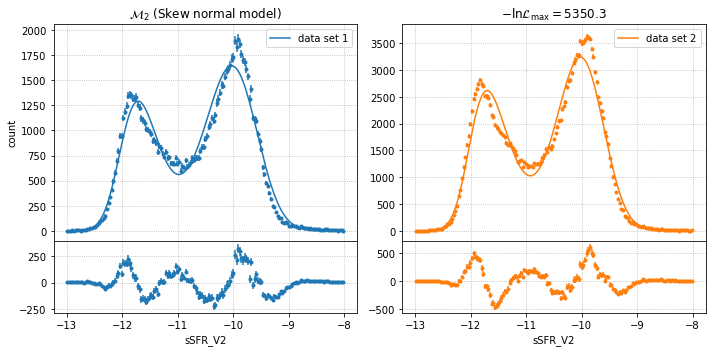

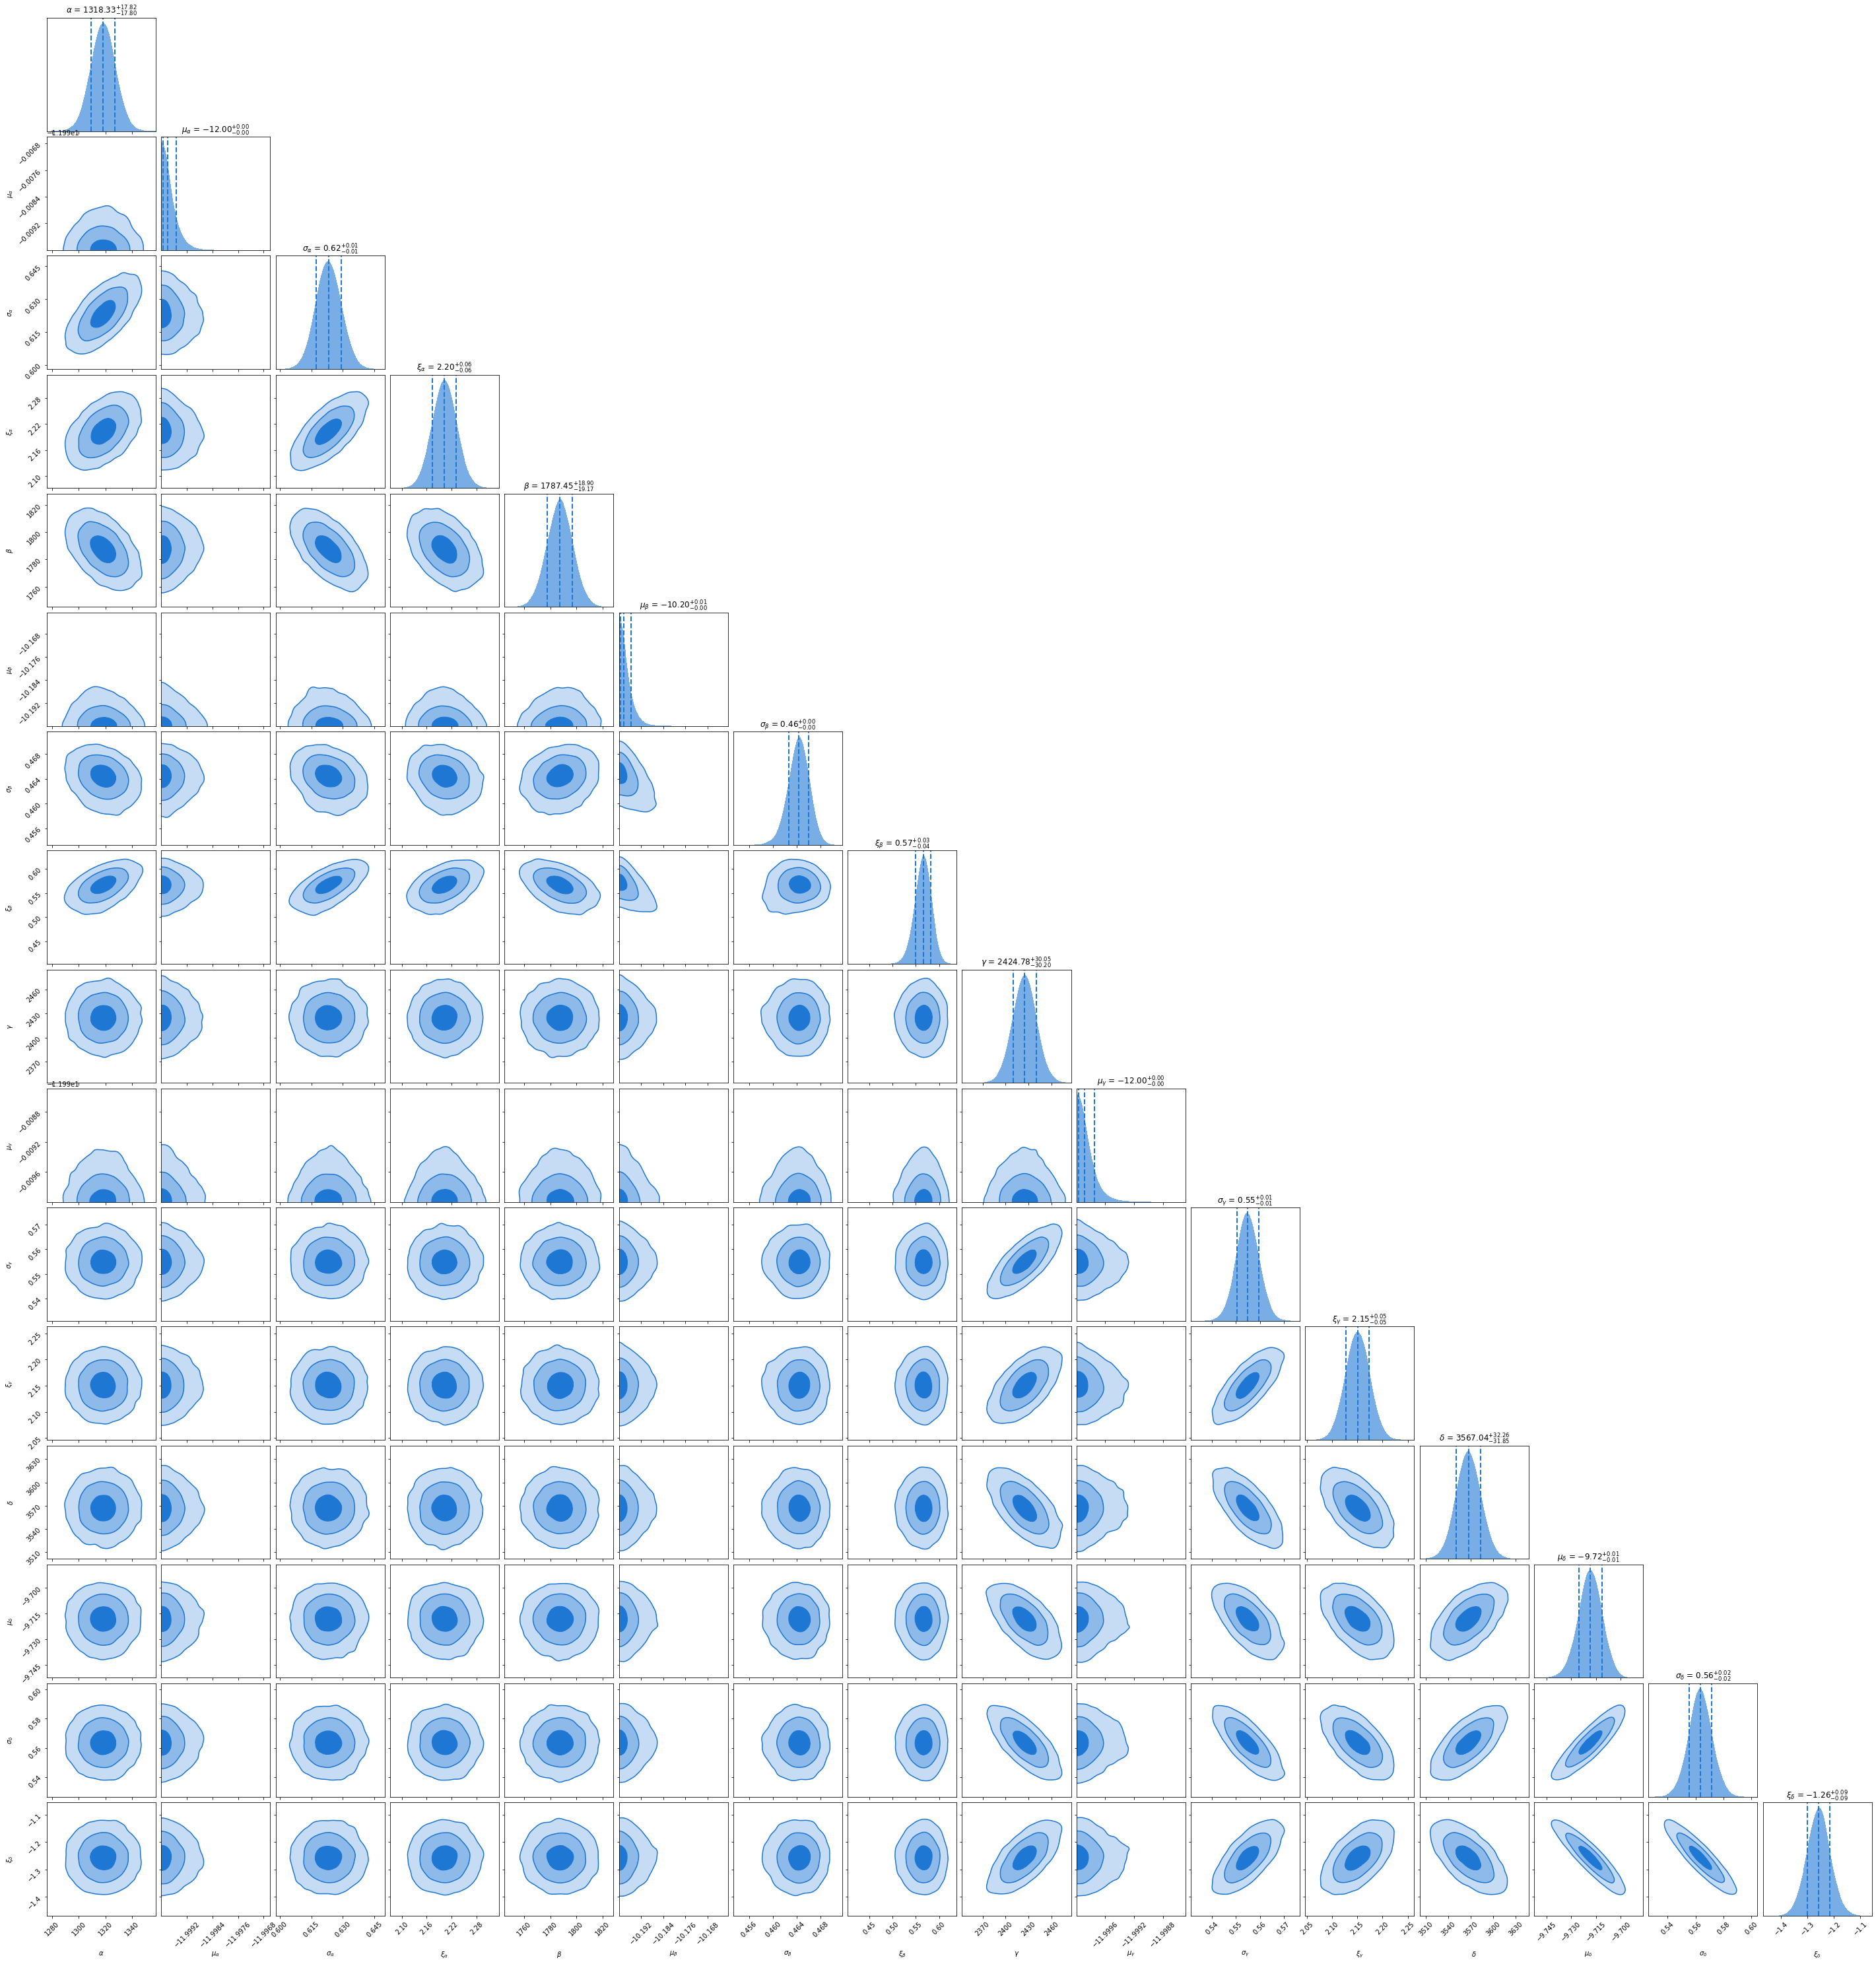

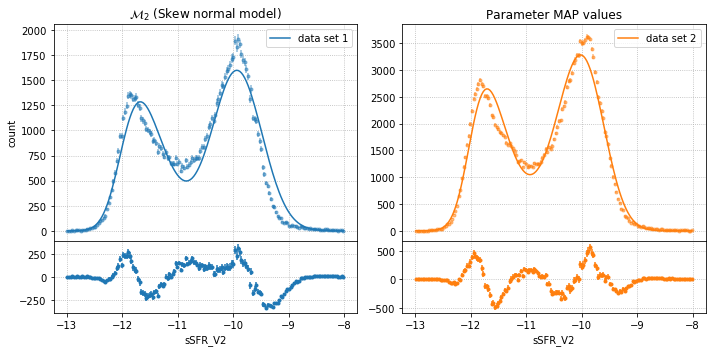

In [18]:
#model2
Model_2_fit(bounds2,data1_wall_v2,data2_void_v2,bins_,label_v2)
Model_2_sampler(prior_xform2,data1_wall_v2,data2_void_v2,bins_,label_v2)
lnZ2_v2 = Model2_output(data1_wall_v2,data2_void_v2,bins_,label_v2)


# #Baye's Factor
# lnB12_v2 = lnZ1_v2 - lnZ2_v2
# logB12_v2 = 0.434 * lnB12_v2

# print("Log of Baye's Factor for g-r using V2 is: ", logB12_v2)